In [1]:
%matplotlib inline
import random

import time

# random.seed(0)
import mlrose
import numpy as np
import seaborn as sns
import warnings
from datetime import datetime
warnings.simplefilter('ignore')
import pandas as pd
from util import init_weights, compute_loss, perturb_weights, plot_loss
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, auc, accuracy_score, classification_report, roc_auc_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from matplotlib.legend_handler import HandlerLine2D
from sklearn.model_selection import train_test_split, KFold, cross_val_score, learning_curve, GridSearchCV, validation_curve

In [2]:
data1 = pd.read_csv("datasets/pulsar/pulsar_stars.csv", dtype=np.float32)
Y1 = np.array(data1.pop("target_class"))
X1 = np.array(data1)
X_train, X_test, y_train, y_test = train_test_split( X1, Y1, test_size = 0.3)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [3]:
kf = KFold(n_splits=5)
acc_tr = {}
time_tr = {}
acc_val = {}
acc_te = {}

def evaluate(algo_name, param_name, clf, kf):
    
    if algo_name not in acc_tr:
        acc_tr[algo_name] = {}
        acc_te[algo_name] = {}
        acc_val[algo_name] = {}
        time_tr[algo_name] = {}
    if param_name not in acc_tr[algo_name]:
        acc_tr[algo_name][param_name] = []
        acc_te[algo_name][param_name] = []
        acc_val[algo_name][param_name] = []
        time_tr[algo_name][param_name] = []
    eval_time = []
    eval_tr = []
    eval_te = []
    eval_val = []
    
    for train_index, val_index in kf.split(X_train):
        x_tr, x_val = X_train, X_train#X_train[train_index], X_train[val_index]
        y_tr, y_val = y_train, y_train#y_train[train_index], y_train[val_index]
        

        time_start = time.time()#datetime.now()
        clf.fit(x_tr, y_tr)
        time_end = time.time()
        eval_time.append(time_end - time_start)#(datetime.now() - time_start).microseconds)
        
        y_train_pred = clf.predict(x_tr)
        y_val_pred = clf.predict(x_val)
        y_train_accuracy = accuracy_score(y_tr, y_train_pred)
        y_val_accuracy = accuracy_score(y_val, y_val_pred)
        eval_tr.append(y_train_accuracy)    
        eval_val.append(y_val_accuracy)
#         if algo_name=='ga':
        break
        
#     print(eval_time)
    eval_time = np.array(eval_time).mean()
    eval_tr = np.array(eval_tr).mean()
    eval_val = np.array(eval_val).mean()

    y_test_pred = clf.predict(X_test)
    y_test_accuracy = accuracy_score(y_test, y_test_pred)
    
    acc_tr[algo_name][param_name].append(eval_tr)
    acc_val[algo_name][param_name].append(eval_val)
    acc_te[algo_name][param_name].append(y_test_accuracy)    
    time_tr[algo_name][param_name].append(eval_time)
    return eval_val

## Gradient descent

In [4]:
iteration_range = range(300, 1501, 300)

best_val_score = -1
best_clf = ""
for it in iteration_range:
    print("Eval iter", it)

    algo = 'gd'
    clf = mlrose.NeuralNetwork(hidden_nodes=[10,3], activation='relu', algorithm='gradient_descent',
                              max_iters=it, bias=True, is_classifier=True, learning_rate=0.0001, 
                              early_stopping=True, clip_max=1, max_attempts=100)
    score = evaluate(algo, 'iter', clf, kf)
    if best_val_score<score:
        best_val_score = score
        best_clf = clf

Eval iter 300
Eval iter 600
Eval iter 900
Eval iter 1200
Eval iter 1500


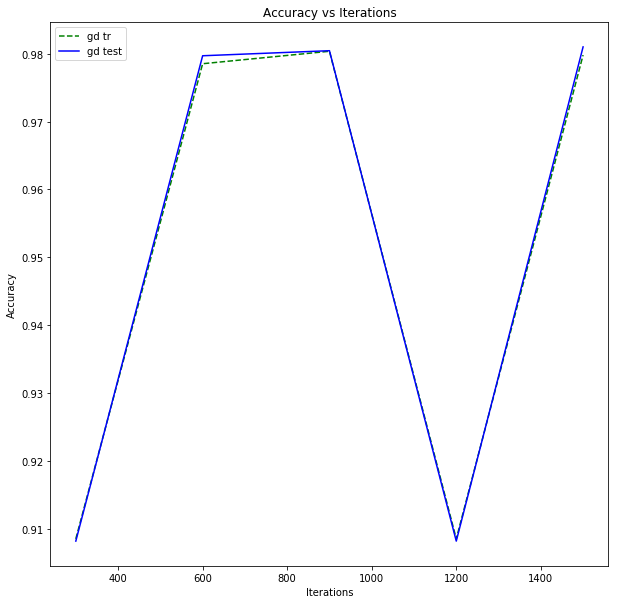

In [5]:
plt.figure(figsize=(10, 10))
plt.plot(iteration_range, acc_tr['gd']['iter'], label='gd tr', linestyle='--', color='g')
# plt.plot(iteration_range, acc_te['gd']['iter'], label='gd val', linestyle='-', color='b')
plt.plot(iteration_range, acc_te['gd']['iter'], label='gd test', linestyle='-', color='b')

plt.ylabel("Accuracy")
plt.xlabel("Iterations")
plt.title("Accuracy vs Iterations")
plt.legend(loc='best')

In [6]:
print(classification_report(y_test, best_clf.predict(X_test)))

             precision    recall  f1-score   support

        0.0       0.99      0.99      0.99      4877
        1.0       0.92      0.86      0.89       493

avg / total       0.98      0.98      0.98      5370



## GA

In [7]:
iteration_range = range(300, 1501, 300)

best_val_score = -1
best_clf = ""

for it in iteration_range:
    print("Eval iter", it)

    algo = 'ga'
    clf = mlrose.NeuralNetwork(hidden_nodes=[10,3], activation='relu', algorithm='genetic_alg',
                              max_iters=it, bias=True, is_classifier=True, learning_rate=0.0001, 
                              early_stopping=True, clip_max=1, max_attempts=100)
    score = evaluate(algo, 'iter', clf, kf)
    if best_val_score<score:
        best_val_score = score
        best_clf = clf

Eval iter 300
Eval iter 600
Eval iter 900
Eval iter 1200
Eval iter 1500


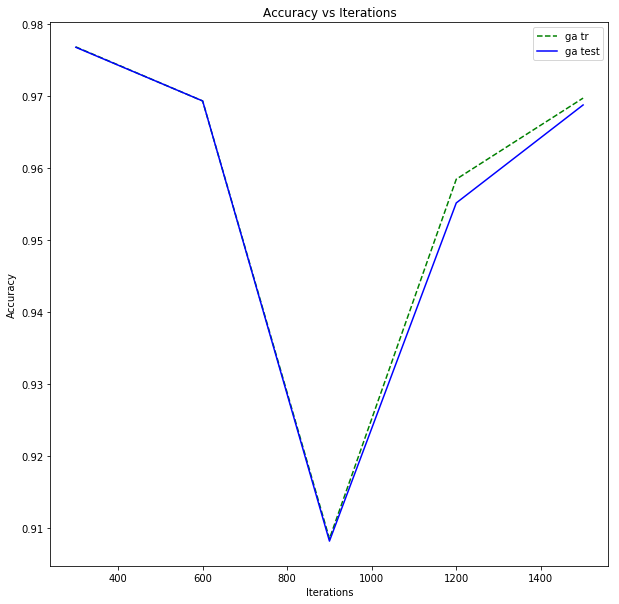

In [8]:
plt.figure(figsize=(10, 10))
plt.plot(iteration_range, acc_tr['ga']['iter'], label='ga tr', linestyle='--', color='g')
plt.plot(iteration_range, acc_te['ga']['iter'], label='ga test', linestyle='-', color='b')

plt.ylabel("Accuracy")
plt.xlabel("Iterations")
plt.title("Accuracy vs Iterations")
plt.legend(loc='best')

In [9]:
print(classification_report(y_test, best_clf.predict(X_test)))

             precision    recall  f1-score   support

        0.0       0.98      0.99      0.99      4877
        1.0       0.93      0.80      0.86       493

avg / total       0.98      0.98      0.98      5370



## Training time

In [10]:
print("Training time for GD in seconds")
print(np.mean(time_tr['gd']['iter']))

Training time for GD in seconds
38.2584222317


In [11]:
print("Training time for GA in seconds")
print(np.mean(time_tr['ga']['iter']))

Training time for GA in seconds
491.567615271
